# Spateo's modeling
## 1.Choose gene set for testing: highly spatially autocorrelated genes. (morani)
These potentially reflect signaling patterns that are uniform across spatial domains and have potentially interesting relationships cell-cell interaction events.

## 2.Run niche model to predict RNA counts based on cell type pair proximity. 
Use the spatially autocorrelated genes above as the targets.

## 3.Run niche L:R model to predict RNA counts based on cell type-specific signatures of L:R interaction. 
LR pairs results based on the '2.cci_analysis results.ipynb', and use the spatially autocorrelated genes found above as the targets.

## 4. Results from the niche model
## 5. Results from the niche L:R model

In [5]:
import os
import sys
sys.path.insert(0,'/DATA/User/zuolulu/test/spateo-release')
import spateo as st
from anndata import read_h5ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import anndata as ad

# Load data (injured data)

In [7]:
os.chdir('/DATA/User/zuolulu/06.axolotl/')
os.getcwd()

'/DATA/User/zuolulu/06.axolotl'

In [8]:
color_key={'CCKIN': '#99cfdd',
 'CMPN': '#ccc8fb',
 'CP': '#666666',
 'dpEX': '#fffe2e',
 'IMN': '#95c454',
 'MCG': '#04047d',
 'mpEX': '#4ec602',
 'MPIN': '#1c9d79',
 'MSN': '#775613',
 'nptxEX': '#b904ab',
 'NPYIN': '#b58396',
 'NTNG1EX': '#fe3030',
 'OBNBL': '#02ffff',
 'OLIGO': '#AF5F3C',
 'reaEGC': '#e72988',
 'ribEGC': '#8eb3fb',
 'rIPC1': '#4166b0',
 'rIPC2': '#59BE86',
 'rIPC3': '#ffd29a',
 'rIPC4': '#C798EE',
 'SCGNIN': '#e9c62a',
 'sfrpEGC': '#767da3',
 'SSTIN': '#525510',
 'TLNBL': '#4fbad6',
 'UnKnown': '#D1D1D1',
 'VLMC': '#FEB915',
 'wntEGC': '#828282',
 'WSN': '#6D1A9C'}

In [21]:
right = ad.read("/DATA/User/zuolulu/06.axolotl/data/mydata/right.h5ad")
right.uns['__type'] = 'UMI'
right

AnnData object with n_obs × n_vars = 3625 × 27324
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'inj_M_L', 'Annotation', 'spec'
    var: 'Axolotl_ID', 'hs_gene'
    uns: 'Annotation_colors', '__type'
    obsm: 'X_pca', 'X_spatial', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

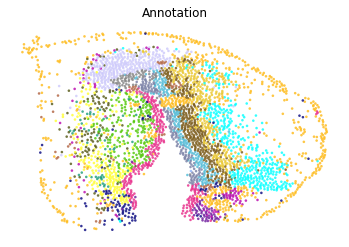

In [22]:
fig, ax = plt.subplots()
st.pl.space(right, color=['Annotation'], pointsize=0.1,color_key=color_key,show_legend=False,ax=ax)
fig.subplots_adjust(right=0.7)
plt.rcParams['pdf.fonttype'] = 42
fig.set_size_inches(3,3)
#fig.savefig("2DPI.cluster.anno.pdf")

In [29]:
axolotl_2dpi = right

# 1. Gene set for testing: highly spatially autocorrelated genes. 
These potentially reflect signaling patterns that are uniform across spatial domains and have potentially interesting relationships cell-cell interaction events.

In [30]:
os.chdir('/DATA/User/zuolulu/06.axolotl/result-1023')
os.getcwd()

'/DATA/User/zuolulu/06.axolotl/result-1023'

In [31]:
# Output directory:
save_dir = '.'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#### morani

In [10]:
m_degs = st.tl.moran_i(axolotl_2dpi)
m_filter = m_degs[(m_degs.moran_i > 0.1) & (m_degs.moran_q_val < 0.05)].sort_values(by=['moran_i'], ascending=False)
# Save to .csv:
m_filter.to_csv(os.path.join(save_dir, 'axolotl_2dpi_moran.csv'))

In [32]:
m_filter = pd.read_csv(os.path.join(save_dir, 'axolotl_2dpi_moran.csv'))

In [33]:
# Filter down to genes w/ Moran's i >= 0.4 and expressed in at least 5% of cells:
m_filter = m_filter[m_filter['moran_i'] > 0.4]
axolotl_adata = adata
n_cells = axolotl_adata.n_obs
to_keep = []
for gene in m_filter.index:
    axolotl_adata_sub = axolotl_adata[:, gene]
    if scipy.sparse.issparse(axolotl_adata_sub.X):
        n_cells_by_counts = axolotl_adata_sub.X.getnnz(axis=0)
    else:
        n_cells_by_counts = np.count_nonzero(axolotl_adata_sub.X, axis=0)
    if n_cells_by_counts >= 0.05 * n_cells:
        to_keep.append(gene)
        
targets = m_filter.loc[to_keep]

In [34]:
targets

,Axolotl_ID,moran_i,moran_p_val,moran_z,moran_q_val
5,AMEX60DD041912,0.702088,0.005,71.204317,0.035357
12,AMEX60DD023492,0.619814,0.005,62.190959,0.035357
26,AMEX60DD038981,0.542571,0.005,56.044881,0.035357
34,AMEX60DDU001033882,0.516351,0.005,55.896494,0.035357
36,AMEX60DDU001010550,0.514014,0.005,150.624811,0.035357
37,AMEX60DD021318,0.512877,0.005,53.106747,0.035357
50,AMEX60DD016339,0.466396,0.005,48.296279,0.035357
61,AMEX60DD022464,0.437204,0.005,34.854825,0.035357
67,AMEX60DD024109,0.428605,0.005,48.959965,0.035357
69,AMEX60DD034100,0.417779,0.005,39.297394,0.035357


#### (optional) Processing of axolotl data.

In [36]:
# Process to human-equivalent gene names(SOD2 maps to two different genes...)
axolotl_2dpi = axolotl_2dpi[:, axolotl_2dpi.var['hs_gene'] != 'SOD2']
axolotl_2dpi = axolotl_2dpi[:, axolotl_2dpi.var['hs_gene'] != "-"]
axolotl_2dpi.var_names = axolotl_2dpi.var['hs_gene']
left = left[:, left.var['hs_gene'] != 'SOD2']
left = left[:, left.var['hs_gene'] != "-"]
left.var_names = left.var['hs_gene']

#### Process for Poisson regression

In [37]:
axolotl_2dpi.layers['processed_counts'] = axolotl_2dpi.X
axolotl_2dpi.X = axolotl_2dpi.layers['counts']
left.X = left.layers['counts']

In [38]:
axolotl_2dpi.var

,Axolotl_ID,hs_gene
hs_gene,,
ZNF461,AMEX60DDU001013765,ZNF461
ZNF607,AMEX60DDU001013047,ZNF607
ZNF684,AMEX60DDU001012170,ZNF684
NFATC1,AMEX60DDU001005462,NFATC1
RBIS,AMEX60DDU001001857,RBIS
...,...,...
TMEM67,AMEX60DD017554,TMEM67
SLC7A9,AMEX60DD017607,SLC7A9
TPM4,AMEX60DD014180,TPM4


In [39]:
targets = axolotl_2dpi.var[axolotl_2dpi.var['Axolotl_ID'].isin(targets['Axolotl_ID'])].index.tolist()

In [40]:
targets

['AGR2', 'AQP1', 'RTN1', 'FTL', 'SLC1A3', 'SCGN', 'FABP7']

# 2. Run niche model to predict RNA counts based on cell type pair proximity. 
Use the spatially autocorrelated genes above as the targets.

In [51]:
# Output directory:
save_dir = './glm_outputs'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [52]:
# Unique ID to save file to:
from datetime import datetime
save_id = datetime.today().strftime('%Y-%m-%d')

In [53]:
targets = targets + ['FZD2']

# Data preprocessing is handled at object instantiation. Also data_id sets a unique identifier name to save
# pairwise distance arrays & nearest neighbor arrays to, under folder 'neighbors'.
niche_interp = st.tools.Niche_Interpreter(
    axolotl_2dpi, 
    group_key='Annotation',
    genes=targets,
    smooth=False,
    normalize=False,
    log_transform=False,
    weights_mode="knn",
    distr="poisson",
    data_id="axolotl_2dpi",
)

# Fit model, return coefficients (some other quantities of interest save to the AnnData object):
# reg_lambda: discrete values of lambda regularization parameter to test
# n_jobs: number of parallel processes to run (genes to fit on in parallel)
niche_coeffs, _ = niche_interp.GLMCV_fit_predict(
    reg_lambda=np.logspace(np.log(1e-3), np.log(1e-4), 3, base=np.exp(1)),
    n_jobs=30
)

niche_coeffs.to_csv(f'./glm_outputs/axolotl_2dpi_niche_coeffs_{save_id}.csv')

|-----> Note: argument provided to 'genes' represents the dependent variables for non-ligand-based analysis, but are used as independent variables for ligand-based analysis.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----> Checking for pre-computed adjacency matrix for dataset axolotl_2dpi...
|-----> Adjacency matrix loaded from file.
|-----> Optimal lambda regularization value for AGR2: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for AQP1: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for RTN1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SLC1A3: 0.0010000000000000007.
|-----> Optimal lambda regularization value for FTL: 0.000316227766016838.
|-----> Optimal lambda regularization value for FZD2: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for FABP7: 9.999999999999996e-05.
|-----> Optimal lambda regularization value for SCGN: 9.999999999999996e-05.


In [54]:
niche_coeffs

,group_CMPN-group_CMPN,group_MCG-group_CMPN,group_MPIN-group_CMPN,group_MSN-group_CMPN,group_OBNBL-group_CMPN,group_OLIGO-group_CMPN,group_SCGNIN-group_CMPN,group_SSTIN-group_CMPN,group_TLNBL-group_CMPN,group_VLMC-group_CMPN,...,group_TLNBL-group_wntEGC,group_VLMC-group_wntEGC,group_WSN-group_wntEGC,group_dpEX-group_wntEGC,group_mpEX-group_wntEGC,group_nptxEX-group_wntEGC,group_reaEGC-group_wntEGC,group_ribEGC-group_wntEGC,group_sfrpEGC-group_wntEGC,group_wntEGC-group_wntEGC
AGR2,-0.424812,-0.003080,0.000000,-0.009893,-0.016775,-0.011738,-0.027896,-0.032663,-0.000528,-0.046293,...,-0.023727,-0.001994,-0.0,0.000000,0.000000,-0.0,-0.017665,0.000000,-0.042179,-0.106070
AQP1,-0.702293,-0.040650,-0.000944,-0.071282,0.000516,-0.058243,-0.035872,-0.149425,-0.057222,-0.021993,...,0.396070,0.328268,-0.0,0.000000,-0.001407,-0.0,0.159170,0.000000,0.169080,1.089148
RTN1,0.308323,0.000000,0.000000,0.108545,-0.000000,0.020443,-0.017510,0.000000,0.121263,0.018833,...,0.045417,0.000000,-0.0,0.000000,0.000000,-0.0,-0.069205,0.000000,-0.103315,-0.453073
FTL,-0.598832,-0.045357,0.000000,-0.083698,0.125530,-0.112633,-0.000000,0.000557,-0.025049,-0.150848,...,-0.094102,-0.160341,-0.0,0.066848,0.000000,-0.0,-0.085815,0.000000,-0.013247,-0.054304
SLC1A3,-0.278963,-0.000000,-0.000000,-0.000000,-0.000000,-0.228398,-0.098554,0.007210,0.036807,-0.031447,...,0.140320,0.158064,-0.0,0.042868,-0.000000,-0.0,0.139444,-0.000000,0.036284,0.790598
SCGN,0.092764,0.035619,-0.051707,-0.355007,0.071599,-0.168732,0.156574,0.025942,-0.056125,0.106089,...,-0.146330,-0.060599,-0.0,0.009335,-0.005746,-0.0,-0.089935,-0.011909,-0.121819,-0.283462
FZD2,-0.526047,-0.000000,-0.032519,-0.020775,-0.070670,-0.016703,-0.031409,-0.095679,-0.006095,-0.015876,...,0.222032,0.028789,-0.0,0.021698,-0.001323,-0.0,0.352622,0.079577,0.334998,1.139178
FABP7,-0.525241,-0.032895,-0.017767,-0.084706,-0.046133,-0.109982,0.100129,-0.004822,-0.011415,-0.213638,...,0.261768,0.175919,-0.0,0.012383,0.032348,-0.0,-0.218269,0.069161,0.331099,0.882790


# 3. Run niche L:R model to predict RNA counts based on cell type-specific signatures of L:R interaction. 
LR pairs results based on the '1.cci_analysis results.ipynb', and use the spatially autocorrelated genes found above as the targets.

In [55]:
# Name of the directory containing 'human_mouse_signaling_network.csv'
cci_dir_path = "/DATA/User/zuolulu/test/spateo-release/spateo/tools/database"

In [56]:
targets = targets + ['FZD2']

# Data preprocessing is handled at object instantiation. 
# data_id sets a unique identifier name to save pairwise distance arrays & nearest neighbor arrays to, under folder 'neighbors'.
# cci_dir is the name of the directory containing 'human_mouse_signaling_network.csv'.
# niche_lr_r_lag is a flag that sets the exogenous variable to the spatial lag of the target gene expression. 
niche_lr_interp = st.tools.Niche_LR_Interpreter(
    adata=axolotl_2dpi,
    group_key='Annotation',
    smooth=False,
    normalize=False,
    log_transform=False,
    weights_mode="knn",
    niche_lr_r_lag=False,
    lig=["L1CAM", "PTN", "TNC"],
    rec=["ERBB3", "SDC1"],
    species="axolotl",
    data_id="axolotl_2dpi",
    distr="poisson",
    cci_dir=cci_dir_path
)

# Fit model, return coefficients (some other quantities of interest save to the AnnData object):
# categories: cell type labels to subset to (fits to counts of target gene for only the chosen cell types)
# reg_lambda: discrete values of lambda regularization parameter to test
# n_jobs: number of parallel processes to run (genes to fit on in parallel)
nlr_coeffs, _ = niche_lr_interp.GLMCV_fit_predict(
    cat_key='Annotation', 
    categories=['reaEGC', 'WSN'],                    
    reg_lambda=np.logspace(np.log(1e-3), np.log(1e-5), 3, base=np.exp(1)),
    n_jobs=30
)

nlr_coeffs.to_csv(f'./glm_outputs/axolotl_2dpi_niche_lr_coeffs_{save_id}.csv')

|-----> Note: argument provided to 'genes' represents the dependent variables for non-ligand-based analysis, but are used as independent variables for ligand-based analysis.
|-----> Predictor arrays for :class `Niche_LR_Interpreter` are extremely sparse. It is recommended to provide categories to subset for :func `GLMCV_fit_predict`.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----> Checking for pre-computed adjacency matrix for dataset axolotl_2dpi...
|-----> Adjacency matrix loaded from file.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----? Length of the provided list of ligands (input to 'l') does not match the length of the provided list of receptors (input to 'r'). This is fine, so long as all ligands and all receptors have at least one match in the other list.
Setting up Niche-L:R model using the following ligand-receptor pairs: [('L1CAM', 'ERBB3'), ('PTN', 'SDC1'), ('TNC', 'SDC1')]
|-----> Starting fr

2022-10-24 17:11:49.266190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zuolulu/miniconda3/envs/spateo/lib/python3.8/site-packages/opencv_python-4.5.5.64-py3.8-linux-x86_64.egg/cv2/../../lib64:/home/zuolulu/miniconda3/envs/spateo/lib/python3.8/site-packages/opencv_python-4.5.5.64-py3.8-linux-x86_64.egg/cv2/../../lib64:
2022-10-24 17:11:49.335550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zuolulu/miniconda3/envs/spateo/lib/python3.8/site-packages/opencv_python-4.5.5.64-py3.8-linux-x86_64.egg/cv2/../../lib64:/home/zuolulu/miniconda3/envs/spateo/lib/python3.8/site-packages/opencv_python-4.5.5.64-py3.8-linux-x86_64.egg/cv2/../../l

|-----> Optimal lambda regularization value for PIK3R1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SHC3: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SHC2: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for HRAS: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CALML5: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CALM1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for SHC4: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CALM3: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CALML4: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for PLCG1: 0.0010000000000000007.
|-----> Optimal lambda regularization value for ITGB3: 1.0000000000000004e-05.
|-----> Optimal lambda regularization value for ITGAV: 0.0010000000000000007.
|-----> Optimal lambda regularization value for CALML3: 1.0000

In [57]:
nlr_coeffs

,group_MCG-group_reaEGC_L1CAM-ERBB3,group_VLMC-group_WSN_L1CAM-ERBB3,group_VLMC-group_reaEGC_L1CAM-ERBB3,group_WSN-group_WSN_L1CAM-ERBB3,group_WSN-group_nptxEX_L1CAM-ERBB3,group_WSN-group_reaEGC_L1CAM-ERBB3,group_dpEX-group_reaEGC_L1CAM-ERBB3,group_mpEX-group_reaEGC_L1CAM-ERBB3,group_nptxEX-group_WSN_L1CAM-ERBB3,group_reaEGC-group_OLIGO_L1CAM-ERBB3,...,group_WSN-group_nptxEX_TNC-SDC1,group_WSN-group_reaEGC_TNC-SDC1,group_dpEX-group_reaEGC_TNC-SDC1,group_nptxEX-group_WSN_TNC-SDC1,group_reaEGC-group_MCG_TNC-SDC1,group_reaEGC-group_WSN_TNC-SDC1,group_reaEGC-group_dpEX_TNC-SDC1,group_reaEGC-group_mpEX_TNC-SDC1,group_reaEGC-group_reaEGC_TNC-SDC1,group_sfrpEGC-group_reaEGC_TNC-SDC1
HSP90B1,0.135793,0.043113,-0.475639,-0.000842,-0.000000,-0.177469,-0.229916,0.007975,-0.143849,-0.000000,...,-0.000000,-0.000000,0.431423,0.331927,-0.000000,-0.000000,-0.000000,-0.000000,0.133051,-0.178548
KRAS,-0.332584,-0.017179,-0.088387,-0.159676,-0.000000,0.135757,0.455380,0.179582,-0.080618,-0.000000,...,-0.000000,-0.068917,0.000000,0.110455,-0.000000,0.150025,-0.000000,-0.000000,-0.659394,0.000000
CTNNB1,0.278810,0.427097,-0.023787,0.140627,-0.000000,0.457606,-0.045172,-0.303180,-0.234337,-0.000000,...,-0.000000,0.042641,0.034925,-0.000000,-0.000000,0.008176,-0.000000,-0.000000,0.078914,-0.000000
HIF1A,-0.255971,-0.105982,-0.108077,-0.091370,-0.000000,-0.226879,0.028105,0.337079,-0.016805,0.036959,...,-0.000000,-0.211137,-0.120562,-0.116434,0.028073,-0.296076,-0.012357,-0.000000,-0.196935,-0.084454
PIK3R3,0.221213,-0.204599,0.249548,-0.200052,-0.000000,-0.008382,0.059883,-0.283536,0.000000,-0.000000,...,-0.000000,-0.105797,-0.000000,-0.013805,-0.000000,-0.101473,-0.000000,-0.000000,-0.016378,-0.000000
PLCG2,-0.021644,-0.041631,0.002438,-0.002807,-0.004023,-0.231633,-0.082435,-0.010636,-0.001928,0.046334,...,0.006359,-0.071710,-0.021834,-0.054749,0.037367,-0.117616,-0.021510,-0.001769,-0.247862,-0.036542
CAV1,-0.204151,-0.035259,0.171092,-0.040806,-0.000000,-0.640147,0.272703,-0.026494,0.000000,-0.000000,...,-0.000000,-0.173596,-0.078501,-0.046164,-0.000000,-0.246758,-0.000000,-0.000000,-0.208334,0.969842
CAV2,-0.080402,-0.030611,-0.112543,-0.111259,-0.000000,-0.000000,0.001896,-0.022139,-0.018858,-0.000000,...,-0.000000,0.294904,0.085067,0.000000,-0.000000,0.025493,-0.000000,-0.000000,-0.000000,-0.035618
SHC2,-0.032263,-0.045762,-0.002787,-0.008696,-0.004023,-0.268221,-0.095016,-0.013524,-0.003915,0.046334,...,0.006359,-0.077938,-0.026998,-0.061206,0.037367,-0.134746,-0.021510,-0.001769,-0.283114,-0.039160
NRAS,0.094309,0.160985,-0.000000,0.080220,-0.000000,-0.036748,-0.000680,-0.075788,-0.018109,-0.000000,...,-0.000000,-0.028598,-0.216980,0.200532,-0.000000,0.151744,-0.000000,-0.000000,0.151453,-0.088951


# 4. Results from the niche model

In [48]:
# Unique ID for file:
results_save_id = 'axolotl_2dpi_niche'

In [49]:
# Re-instantiate model- inputs don't matter to this (only member functions are needed)
niche_interp = st.tools.Niche_Interpreter(
    axolotl_2dpi, 
    group_key='Annotation', 
    genes=targets, 
    smooth=False,
    normalize=False, 
    log_transform=True, 
    weights_mode="knn", 
    data_id="axolotl_2dpi")
niche_interp.square = True

|-----> Note: argument provided to 'genes' represents the dependent variables for non-ligand-based analysis, but are used as independent variables for ligand-based analysis.
|-----> Log-transforming expression inplace...
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----> Checking for pre-computed adjacency matrix for dataset axolotl_2dpi...
|-----> Adjacency matrix loaded from file.


|-----> With Poisson distribution assumed for dependent variable, using log-transformed data to compute sender-receiver effects...log key not found in adata, manually computing.
|-----? adata.X seems to be already log-transformed.
|-----> Data log-transformed.
                             AGR2   AQP1   RTN1    FTL  SLC1A3   SCGN   FZD2  \
group_CMPN-group_CMPN        True   True   True   True    True  False   True   
group_MCG-group_CMPN        False  False  False  False   False  False  False   
group_MPIN-group_CMPN       False  False  False  False   False  False  False   
group_MSN-group_CMPN        False  False  False  False   False  False  False   
group_OBNBL-group_CMPN      False  False  False  False   False  False  False   
...                           ...    ...    ...    ...     ...    ...    ...   
group_nptxEX-group_wntEGC   False  False  False  False   False  False  False   
group_reaEGC-group_wntEGC   False  False  False  False   False  False   True   
group_ribEGC-group_

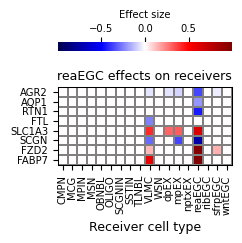

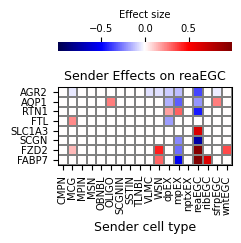

In [58]:
niche_df = pd.read_csv(f'./glm_outputs/axolotl_2dpi_niche_coeffs_{save_id}.csv', index_col=0)

# Compute parameter significance:
niche_interp.get_effect_sizes(
    niche_df, 
    significance_threshold=0.005,                                 
    save_prefix=results_save_id
)

# Type coupling analysis ignoring the effect of cell type in proximity to other cells of the same type (only
# hetero-cell type pairs):
niche_interp.type_coupling(
    cmap="magma", 
    figsize=(4.4, 3.5),                         
    save_kwargs={'prefix': os.path.join('./glm_outputs', results_save_id), 'ext': 'pdf'}
)

# Sender effect: selecting reaEGC as the sender cell and visualizing effects on target genes in receiver cell types (all of the
# other cell types in the system). Visualization will plot the effect size, but qvals can be visualized using 
# 'plot_mode'="qvals":
niche_interp.sender_effect_on_all_receivers(
    save_show_or_return="return",
    sender='reaEGC',
    figsize=(2.75, 7.5),
    #save_kwargs={'prefix': os.path.join('./figures/glm_outputs', results_save_id), 'ext': 'pdf'}
)

# Receiver effect: selecting reaEGC as the receiver cell, visualizing effects on target genes in reaEGC with all other cell
# types in the system as the sender. Visualization will plot the effect size, but qvals can be visualized using 
# 'plot_mode'="qvals":
niche_interp.all_senders_effect_on_receiver(
    save_show_or_return="return",
    receiver='reaEGC',
    figsize=(2.75, 7.5),
    #save_kwargs={'prefix': os.path.join('./figures/glm_outputs', results_save_id), 'ext': 'pdf'}
)

# 5.Results from the niche L:R model

In [59]:
# Unique ID for file:
results_save_id = 'axolotl_2dpi_niche_lr'

In [60]:
# Re-instantiate model- inputs don't matter to this (only member functions are needed)
niche_lr_interp = st.tools.Niche_LR_Interpreter(
    adata=axolotl_2dpi, 
    group_key='Annotation', 
    smooth=False,                                  
    normalize=False, 
    log_transform=True, 
    weights_mode="knn",
    lig=["L1CAM", "PTN", "TNC"], 
    rec=["ERBB3", "SDC1"], 
    species="axolotl",
    data_id="axolotl_2dpi", 
    distr="poisson",
    cci_dir=cci_dir_path
)

|-----> Note: argument provided to 'genes' represents the dependent variables for non-ligand-based analysis, but are used as independent variables for ligand-based analysis.
|-----> Predictor arrays for :class `Niche_LR_Interpreter` are extremely sparse. It is recommended to provide categories to subset for :func `GLMCV_fit_predict`.
|-----> With a poisson assumption, it is recommended to fit to raw counts. Computing normalizations and transforms if applicable, but storing the results for later and fitting to the raw counts.
|-----> Log-transforming expression and storing in adata.layers['X_log1p'], adata.layers['X_norm_log1p'], adata.layers['X_M_s_log1p'], or adata.layers['X_norm_M_s_log1p'], depending on the normalizations and transforms that were specified.
|-----? adata.X seems to be already log-transformed.
|-----> Preparing data: converting categories to one-hot labels for all samples.
|-----> Checking for pre-computed adjacency matrix for dataset axolotl_2dpi...
|-----> Adjacenc

In [61]:
if not os.path.exists('.regr_interpretation'):
    os.makedirs('.regr_interpretation')

In [62]:
# Can choose specific sender-receiver pairs for the plot (recommended, otherwise plot will probably be large to the point of 
# being uninterpretable):
subset_cols=["reaEGC-WSN", "WSN-reaEGC"]

0.5078398069446302


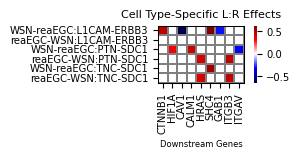

In [63]:
niche_lr_df = pd.read_csv(f'./glm_outputs/axolotl_2dpi_niche_lr_coeffs_{save_id}.csv', index_col=0)

# Heatmap for coefficients:
# zero_center_cmap sets the colormap's median color intensity to 0. 
# Coefficients w/ absolute value larger or smaller than mask_threshold are not assigned color in plot
niche_lr_interp.visualize_params(
    niche_lr_df, 
    subset_cols=subset_cols if subset_cols is not None else None, 
    cmap='seismic', 
    zero_center_cmap=True,                                
    transpose=True, 
    title="Cell Type-Specific L:R Effects", 
    mask_threshold=0.3,
    xlabel="Downstream Genes", 
    figsize=(3, 0.75), 
    save_show_or_return='return',                 
    #save_kwargs={'prefix': os.path.join(f'./figures/regr_interpretation, f"{save_id}_{subset_cols[0]}_etc_params")
)